# BI Txxxx project

## Dataset Preparation

## 1. Installing / Importing libraries suitable for analysis

In [6]:
'''!pip install plotly==4.9.0
!pip install jupyterlab "ipywidgets>=7.5"
!jupyter labextension install jupyterlab-plotly@4.9.0
!jupyter labextension install @jupyter-widgets/jupyterlab-manager plotlywidget@4.9.0
!Check extensions installed jupyter labextension list'''

'!pip install plotly==4.9.0\n!pip install jupyterlab "ipywidgets>=7.5"\n!jupyter labextension install jupyterlab-plotly@4.9.0\n!jupyter labextension install @jupyter-widgets/jupyterlab-manager plotlywidget@4.9.0\n!Check extensions installed jupyter labextension list'

In [2]:
#!jupyter lab build

import plotly.graph_objects as go

In [3]:
#!Pip install fbprophet
import fbprophet

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from datetime import datetime
from dateutil.relativedelta import relativedelta
from fbprophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error

## 2. Data Import and Preprocessing

In [6]:
data = pd.read_csv('/xxx_2020.csv', sep = '","', header =0)

#### 2a. Cleaning data (quotation marks)

* quotation marks and pieces of strings have been removed from columns
* corresponding columns ('"ID' and 'Nombre de points de livraison"') have been replaced

In [7]:
data['ID']= data['"ID'].apply(lambda i: i.strip('"'))
data['Nombre de points de livraison']= data['Nombre de points de livraison"'].apply(lambda i: i.strip('"'))
data=data.drop(['"ID','Nombre de points de livraison"'], axis=1)

#### 2b. Convert column 'Date' in date format

In [8]:
data['Date_livraison']= pd.to_datetime(data['Date'], format= '%d/%m/%Y %H:%M')
max(data['Date_livraison'])

Timestamp('2020-11-13 19:30:00')

#### 2c. Analysis of each column by type (qualitative/quantitative variable)

In [9]:
#data.info()

#### 2d. Visualization of base statistics of quantitative variables

In [10]:
#data.describe()

In [11]:
data['ID'][data['Flag']=='Terminée'].count()

13169

In [13]:
data['Nombre de biens par mission'][data['Flag']=='Terminée'].sum()

274146

## 3. Data exploration and dataset sub-selection

* Creation of new columns 'Date_livraison'
* Subselection of columns regarding to "Volumes des Livraisons" analysis
* Filtering significative values of column "Flag"
* Labelling missing values with "Autre Societé" in column "Societé de Transport"
* Trasformation of "Societé de Transport" values in lowercase

#### 3a. Check of values in column 'Flag' and in column 'Véhicule'



In [12]:
data['Flag'].unique()

array(['Annulée', 'Terminée', 'xxx attribué', 'Non traité',
       'Refacturation'], dtype=object)

In [13]:
data[data['Véhicule']=='undefined'].shape

(29, 38)

In column 'Flag' there are:

* one transaction with value 'Refacturation'
* one transaction 'Non Traité'
* 5942 transactions 'Annulée' (unsuccessful deliveries) that will be taken into account 

In [14]:
pd.set_option('display.max_columns', None)
data[(data['Flag']=='Refacturation') | (data['Flag']=='Non traité')].shape

(2, 38)

#### 3b. Check of values in column 'Societé de Transport'

In [16]:
pd.isnull(data['Société de transport']).sum()

4433

In column 'Société de transport' null values and 'undefined' are labelled as 'Autre Societè' and a new column has been created ('xxx_name'). All names are transformed in lowercase to avoid duplications

In [16]:
data['xxx_name']=  data['Société de transport'].apply(lambda i: 'Livraison_annulée' if pd.isnull(i) or i=='undefined' else i)
data['xxx_name'] = [x.lower() for x in data['xxx_name']]
data['xxx_name'][data['xxx_name']!='livraison_annulée'].nunique()

99

#### 3c. Look at negative values in Prix TTC and Commission xxx TTC Columns
 * MyTxxx get commissions even if Livraison is unsuccessful

In [18]:
##data.loc[data['Prix TTC']<0, ['Prix TTC', 'Comission xxx TTC','Comission Myxxx TTC','Supplément TTC €','xxx_name','Flag']].head()

#### 3d. Create column 'Date_Livraison' and drop unecessary columns

In [19]:
data['ID_livraison']= data['ID']
data = data.drop(['Date','Société de transport', 'ID'], axis=1)

In [20]:
data['N.Livraison']=[i.count(i) for i in data['ID_livraison']]

In [22]:
cols = data.columns.tolist()
cols = ['Date_livraison',
'ID_livraison',
'N.Livraison',
'xxx_name','Type',
'Note client',
'Commercial',
'Numéro de commande',
'Flag',
'Assurance complémentaire',
'Client',
'Formule',
'Véhicule',
'Prix TTC',
'Supplément TTC €',
'Réduction %',
'Code Promo',
'Tag Code Promo',
'Réduction Codoe Promo',
'Prix Trottoir à trottoir TTC',
'Prix Porte à porte 1 xxx TTC',
'Prix Porte à porte 2 xxx TTC',
'Comission Myxxx TTC',
'Comission xxx TTC',
'Distance trajet KM',
'Durée trajet MIN',
'xxx dispatché',
'Origine',
'Provenance',
'Temps de mission calculé',
'Temps de mission réelle',
'Heure du premier bouton "Surplace"',
'Commentaire Myxxx',
'Commentaire xxx',
'Commentaire Pro',
'Nombre de biens par mission',
'IDS charges stripe',
'Nombre de points de livraison']
#data = data [cols]

In [21]:
#data.tail()

#### 3e. Set Date_Livraison as index

In [67]:
#data.set_index('Date_livraison', inplace=True)

#### 3f. Save 'csv' file for Tableau visualization

In [26]:
#data.to_csv('xxx/Dataset_BITxxx_V6.csv')

## 4. Dataset subselection for 'Livraisons' analysis and Time Series

#### 4a. Define new dateset to use for 'Livraisons' analysis and defining new measures ('indicateurs')

* Take into account only successful Livraisons
* Selecting dates by hour

In [27]:
data_t = data[data['Flag']=='Terminée']

#### 4b. Splitting minutes and seconds from date column

In [28]:
data_liv = data_t[['Date_livraison','ID_livraison','xxx_name','Véhicule', 'Nombre de biens par mission']]
data_liv['Date_livraison_hour'] = [x.strftime('%Y-%m-%d %H') for x in data_liv['Date_livraison']]
data_liv['Date_livraison_hour'] = pd.to_datetime(data_liv['Date_livraison_hour'])
data_liv.set_index('Date_livraison_hour', inplace=True)
data_liv = data_liv.drop('Date_livraison', axis=1)

#### 4c. Definining new measures for 'Volumes des livraisons' Analysis and monitoring (on TABLEAU)

In [25]:
'''livraison_hour = pd.DataFrame(data_liv.groupby(['Date_livraison_hour','Véhicule', 'xxx_name'])['ID_livraison'].count())
livraison_hour.head()'''

"livraison_hour = pd.DataFrame(data_liv.groupby(['Date_livraison_hour','Véhicule', 'xxx_name'])['ID_livraison'].count())\nlivraison_hour.head()"

In [109]:
'''TODAY = datetime.today().strftime('%d/%m/%Y')
TODAY_PREV_MONTH = (datetime.today()- relativedelta(months=1)).strftime('%d/%m/%Y')
FIRST_OF_MONTH = (datetime.today()- relativedelta(day=1)).strftime('%d/%m/%Y')
print('Today:',TODAY)
print ('Previous Month:',TODAY_PREV_MONTH)
print ('First of Month:',FIRST_OF_MONTH)'''

"TODAY = datetime.today().strftime('%d/%m/%Y')\nTODAY_PREV_MONTH = (datetime.today()- relativedelta(months=1)).strftime('%d/%m/%Y')\nFIRST_OF_MONTH = (datetime.today()- relativedelta(day=1)).strftime('%d/%m/%Y')\nprint('Today:',TODAY)\nprint ('Previous Month:',TODAY_PREV_MONTH)\nprint ('First of Month:',FIRST_OF_MONTH)"

Defining month to date:

* def today 
* def "today" in previous month
* def first of month

In [25]:
'''for i in range(1,12):
    TODAY_PREV_MONTH = (datetime.today()- relativedelta(months=i)).strftime('%d/%m/%Y')
    print(TODAY_PREV_MONTH)'''


"for i in range(1,12):\n    TODAY_PREV_MONTH = (datetime.today()- relativedelta(months=i)).strftime('%d/%m/%Y')\n    print(TODAY_PREV_MONTH)"

In [111]:
###livraison_jour['ID'][(livraison_jour.index <= TODAY) & (livraison_jour.index <= FIRST_OF_MONTH)].sum()

## Time Series forecasting with FbProphet

### 1. Dataset preparation

#### 1a. Formatting a dataframe as input for FB Prophet Library Models

In [29]:
ds_liv_hr = data_liv.groupby('Date_livraison_hour').agg({'ID_livraison':'count','Nombre de biens par mission':'sum'}).reset_index()
ds_liv_hr.set_index('Date_livraison_hour', inplace=True)

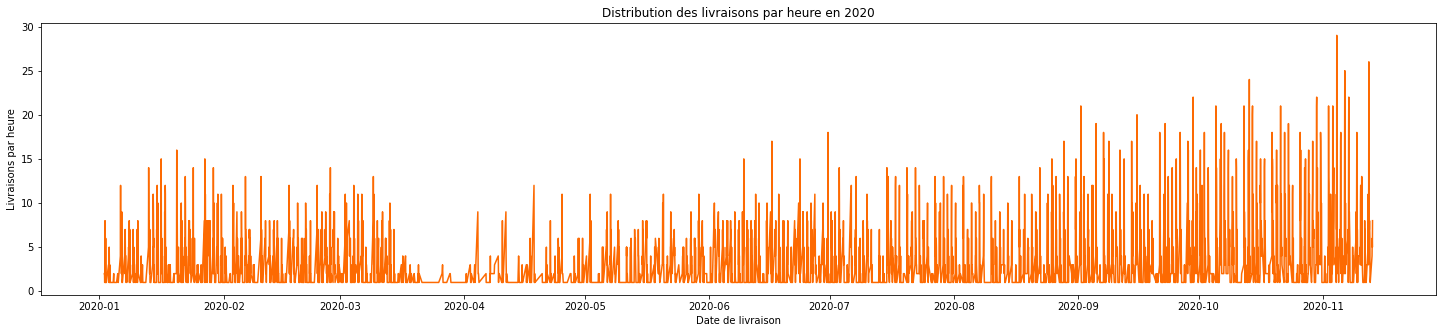

<Figure size 432x288 with 0 Axes>

In [30]:
# Color pallete for plotting
color_pal = ["#FD6A02", "#D39200", "#93AA00",
             "#00BA38", "#00C19F", "#00B9E3",
             "#619CFF", "#DB72FB"]

fig, ax = plt.subplots(1,1, figsize=(25,5))
sns.lineplot(x=ds_liv_hr.index, y = ds_liv_hr["ID_livraison"], color = color_pal[0])
ax.set_xlabel('Date de livraison')
ax.set_ylabel('Livraisons par heure')
ax.title.set_text('Distribution des livraisons par heure en 2020')
plt.show() 
fig1 = plt.figure()
plt.savefig('fig1.pdf')

#### 1b. Defining new time variables to show different trends in time series of Livraisons

### EDA

* Create this collection of new variables :
* date equal to the index
* hour equal to the hour of the day
* dayofweek
* quarter
* month
* year
* ayofyear
* dayofmonth
* weekofyear
* Create an object X containing the above variables and y containing the time series

In [31]:
def create_features(df, label=None):
    """
    Creates time series features from datetime index.
    """
    df = df.copy()
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    if label:
        y = df[label]
        return X, y
    return X

X, y = create_features(ds_liv_hr, label = "ID_livraison")

features_and_target = pd.concat([X, y], axis=1)

In [32]:
features_and_target.head()

In [33]:
np.mean(features_and_target.ID_livraison)

4.0112701797136765

#### 1c. Plotting the Features to see trends

- Plot the time series against hour, dayofweek, year, weekofyear

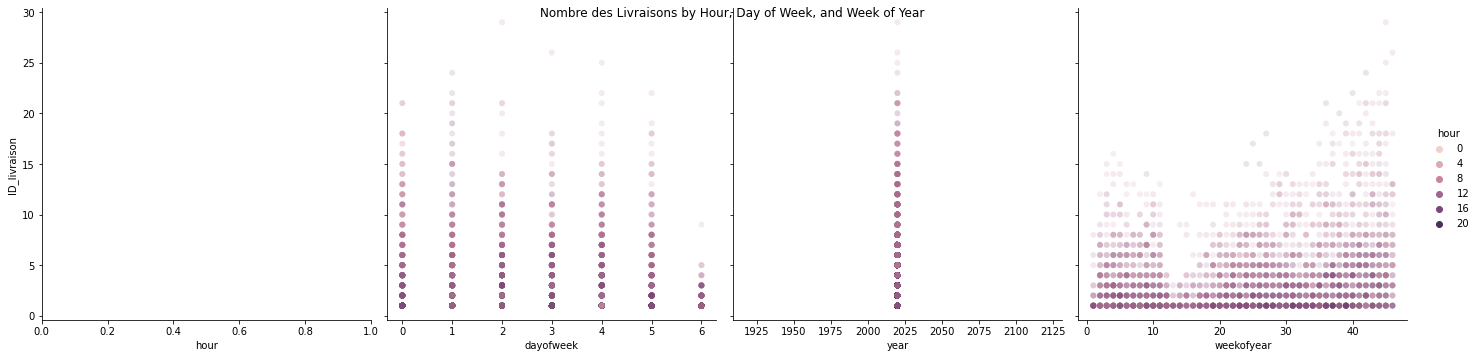

<Figure size 432x288 with 0 Axes>

In [34]:
sns.pairplot(features_and_target.dropna(),
             hue='hour',
             x_vars=['hour','dayofweek','year','weekofyear'],
             y_vars='ID_livraison',
             height=5,
             plot_kws={'alpha':0.15, 'linewidth':0}
            )
plt.suptitle('Nombre des Livraisons by Hour, Day of Week, and Week of Year')
plt.show()
fig2 = plt.figure()
plt.savefig('fig2.pdf')

### 2. HOURLY Time Series Forecasting using Facebook's Prophet


#### 2a. Train and Test Dataset splitting
 - Cutting off last 30 days of data to test the model 

In [35]:
split_date = '2020-10-14 00:00:00'

ds_liv_hr_train = ds_liv_hr.loc[(ds_liv_hr.index <= split_date), 'ID_livraison'].reset_index().copy()
ds_liv_hr_test = ds_liv_hr.loc[(ds_liv_hr.index > split_date), 'ID_livraison'].reset_index().copy()

#### 2b. Plot train and test set

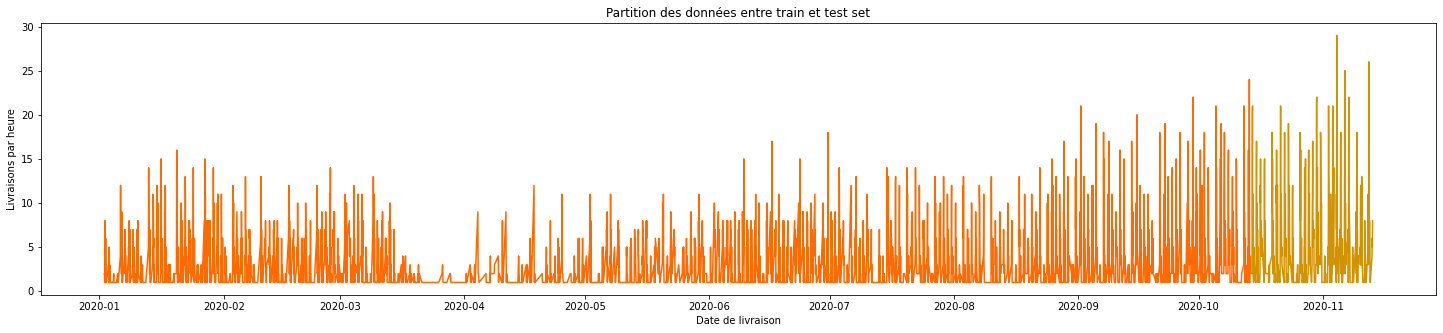

<Figure size 432x288 with 0 Axes>

In [36]:
fig, ax = plt.subplots(1,1, figsize=(25,5))
sns.lineplot(x = ds_liv_hr_train['Date_livraison_hour'], y = ds_liv_hr_train["ID_livraison"], color = color_pal[0])
sns.lineplot(x = ds_liv_hr_test['Date_livraison_hour'], y = ds_liv_hr_test["ID_livraison"], color = color_pal[1])
ax.set_xlabel('Date de livraison')
ax.set_ylabel('Livraisons par heure')
ax.title.set_text('Partition des données entre train et test set')
fig3 = plt.figure()

#### 2c. Defining a DataFrame as required as input to Prophet's library (Train and Test Set)
* ds column corresponding to the time in "YYYY-MM-DD hh" format
* y column corresponding to your target variable

In [37]:
liv_hr_train_prophet = ds_liv_hr_train.rename(columns={'Date_livraison_hour':'ds','ID_livraison':'y'})

In [38]:
liv_hr_test_prophet = ds_liv_hr_test.rename(columns={'Date_livraison_hour':'ds','ID_livraison':'y'})


#### 2d. Instanciation of a Prophet instance and fitting it to our DataFrame

In [39]:
m_hr = Prophet()
m_hr.fit(liv_hr_train_prophet)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


#### 2e. Make predictions on Test set

In [40]:
forecast_hr = m_hr.predict(liv_hr_test_prophet)

In [103]:
'''from fbprophet.plot import plot_plotly
import plotly.offline as py
py.init_notebook_mode()

fig, ax = plt.subplots(1,1, figsize=(25,5))
sns.relplot(x = liv_hr_train_prophet['ds'], y = liv_hr_train_prophet["y"], data= liv_hr_train_prophet, kind='line')
sns.relplot(x = forecast_hr['ds'], y = forecast_hr["yhat"], data=forecast_hr, kind='line')
#fig = plot_plotly(m_hr, forecast_hr)  # This returns a plotly Figure
#py.iplot(fig)'''

'from fbprophet.plot import plot_plotly\nimport plotly.offline as py\npy.init_notebook_mode()\n\nfig, ax = plt.subplots(1,1, figsize=(25,5))\nsns.relplot(x = liv_hr_train_prophet[\'ds\'], y = liv_hr_train_prophet["y"], data= liv_hr_train_prophet, kind=\'line\')\nsns.relplot(x = forecast_hr[\'ds\'], y = forecast_hr["yhat"], data=forecast_hr, kind=\'line\')\n#fig = plot_plotly(m_hr, forecast_hr)  # This returns a plotly Figure\n#py.iplot(fig)'

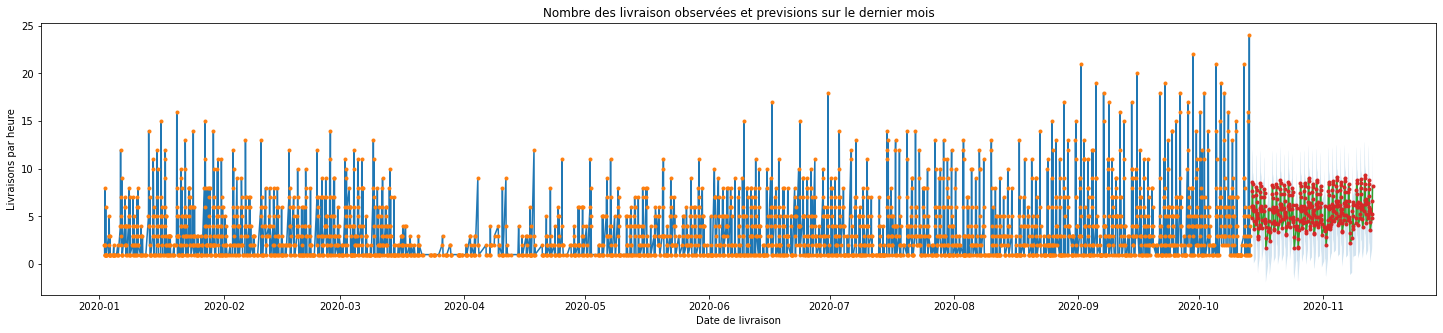

<Figure size 432x288 with 0 Axes>

In [41]:
fig, ax = plt.subplots(1,1, figsize=(25,5))
ax.plot(liv_hr_train_prophet['ds'], liv_hr_train_prophet["y"], "-")
#ax.fill_between(liv_hr_train_prophet['ds'], liv_hr_train_prophet["y"], alpha=0.2)
ax.plot(liv_hr_train_prophet['ds'], liv_hr_train_prophet["y"], '.')
ax.plot(forecast_hr['ds'], forecast_hr["yhat"], '-')
ax.fill_between(forecast_hr['ds'], forecast_hr["yhat_lower"],forecast_hr["yhat_upper"], alpha=0.2)
ax.plot(forecast_hr['ds'], forecast_hr["yhat"], '.')
ax.set_xlabel('Date de livraison')

ax.set_ylabel('Livraisons par heure')
ax.title.set_text('Nombre des livraison observées et previsions sur le dernier mois')
fig4 = plt.figure()

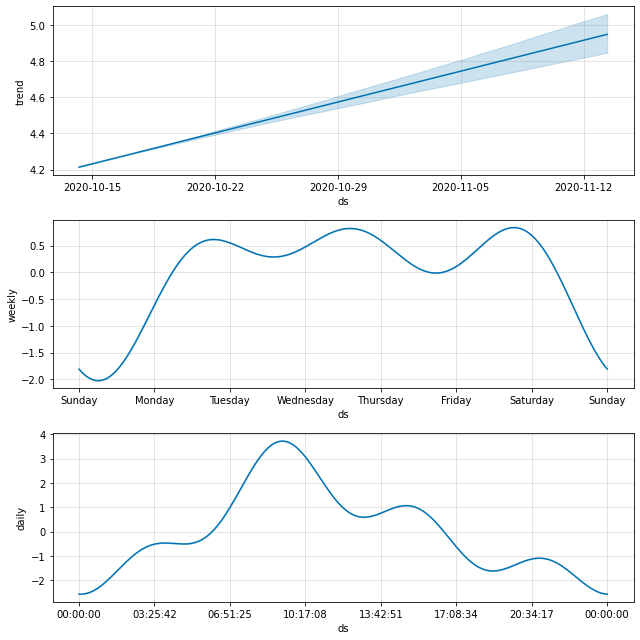

<Figure size 432x288 with 0 Axes>

In [42]:
fig_comp_hr = m_hr.plot_components(forecast_hr)
fig5 = plt.figure()

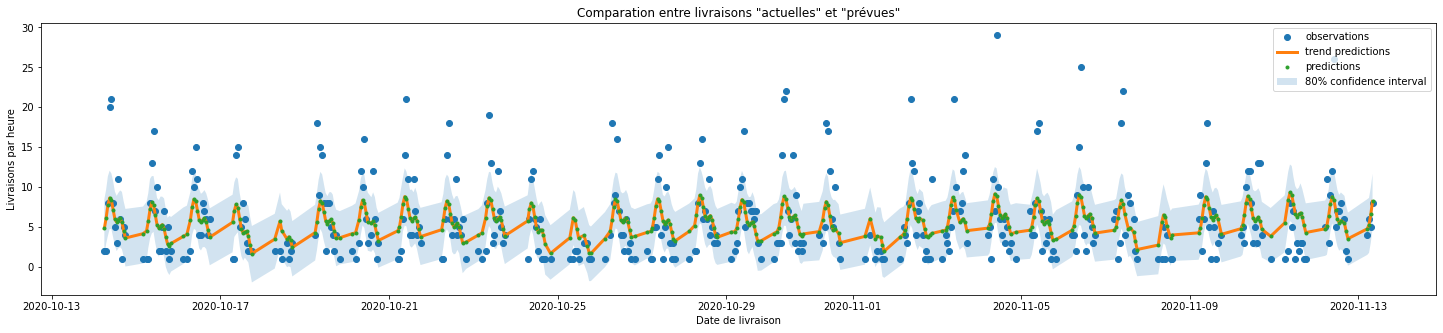

<Figure size 432x288 with 0 Axes>

In [43]:
fig, ax = plt.subplots(1,1, figsize=(25,5))
#ax.plot(liv_hr_test_prophet['ds'], liv_hr_test_prophet["y"], "-")
#ax.fill_between(liv_hr_test_prophet['ds'], liv_hr_test_prophet["y"], alpha=0.2)
ax.plot(liv_hr_test_prophet['ds'], liv_hr_test_prophet["y"], 'o')
ax.plot(forecast_hr['ds'], forecast_hr["yhat"], '-',linewidth=3)
ax.fill_between(forecast_hr['ds'], forecast_hr["yhat_lower"],forecast_hr["yhat_upper"], alpha=0.2)
ax.plot(forecast_hr['ds'], forecast_hr["yhat"], '.')
plt.legend(["observations", "trend predictions", 'predictions', "80% confidence interval"], loc=1)
ax.set_xlabel('Date de livraison')
ax.set_ylabel('Livraisons par heure')
ax.title.set_text('Comparation entre livraisons "actuelles" et "prévues"')
fig6 = plt.figure()

#### 2f. One week of predictions

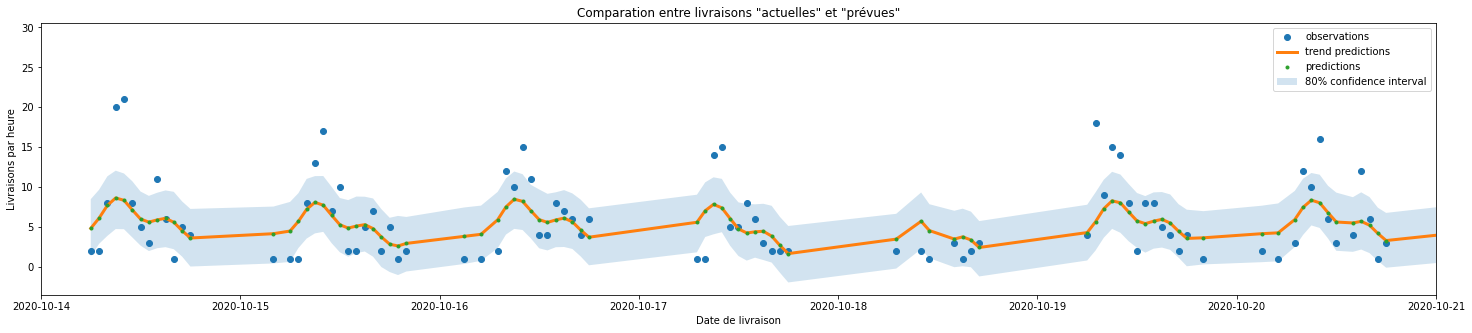

<Figure size 432x288 with 0 Axes>

In [44]:
fig, ax = plt.subplots(1,1, figsize=(25,5))
#ax.plot(liv_hr_test_prophet['ds'], liv_hr_test_prophet["y"], "-")
#ax.fill_between(liv_hr_test_prophet['ds'], liv_hr_test_prophet["y"], alpha=0.2)
ax.plot(liv_hr_test_prophet['ds'], liv_hr_test_prophet["y"], 'o')
ax.plot(forecast_hr['ds'], forecast_hr["yhat"], '-',linewidth=3)
ax.fill_between(forecast_hr['ds'], forecast_hr["yhat_lower"],forecast_hr["yhat_upper"], alpha=0.2)
ax.plot(forecast_hr['ds'], forecast_hr["yhat"], '.')
ax.set_xbound(lower=datetime.strptime('10-14-2020 00:00:00', "%m-%d-%Y %H:%M:%S"),
              upper=datetime.strptime('10-21-2020 00:00:00', "%m-%d-%Y %H:%M:%S"))
plt.legend(["observations", "trend predictions",'predictions', "80% confidence interval"])
ax.set_xlabel('Date de livraison')
ax.set_ylabel('Livraisons par heure')
ax.title.set_text('Comparation entre livraisons "actuelles" et "prévues"')
fig7 = plt.figure()

#### 2h. Calculate MAPE (Mean Absolute Percentage Error) for Hourly model over the test set
$$MAPE = \frac{1}{n}\sum_{t=1}^{n}|\frac{Y_t - \hat{Y_t}}{Y_t}|$$

In [45]:
def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape = mean_absolute_percentage_error(y_true=ds_liv_hr_test['ID_livraison'],
                   y_pred=forecast_hr['yhat'])

print("The MAPE on the test set for the Hourly TS Model is : \n {}".format(mape))

The MAPE on the test set for the Hourly TS Model is : 
 100.87470402520844


### 3. DAILY Time Series Forecasting using Facebook's Prophet

#### 3a. Preprocessing daily data

In [46]:
#ds_liv_hr

In [47]:
ds = ds_liv_hr.groupby(ds_liv_hr.index.date).agg({'ID_livraison':'sum', 'Nombre de biens par mission':'sum'})
#ds.set_index('day_liv', inplace=True)
ds.index=pd.to_datetime(ds.index)

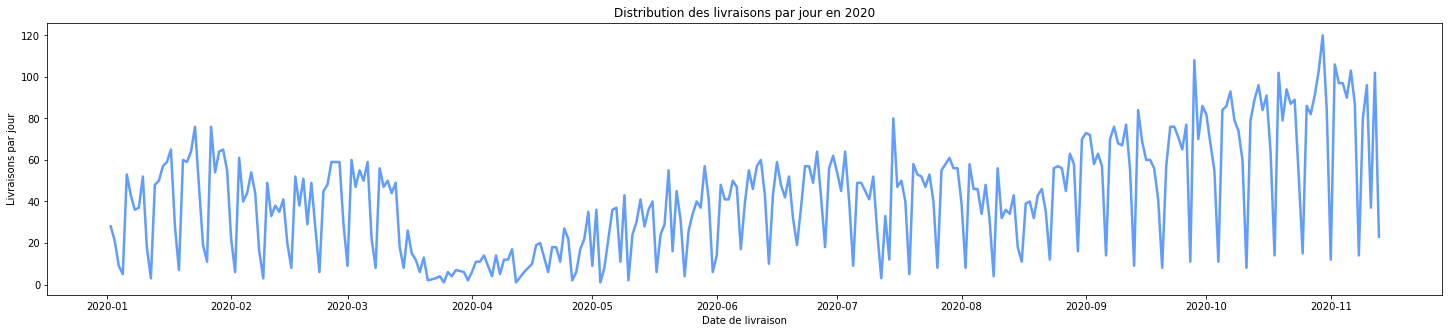

<Figure size 432x288 with 0 Axes>

In [48]:
# Color pallete for plotting
color_pal = ["#F8766D", "#D39200", "#93AA00",
             "#00BA38", "#00C19F", "#00B9E3",
             "#619CFF", "#DB72FB"]

fig, ax = plt.subplots(1,1, figsize=(25,5))
sns.lineplot(x=ds.index, y = ds["ID_livraison"], color = color_pal[6], linewidth = 2.5)
ax.set_xlabel('Date de livraison')
ax.set_ylabel('Livraisons par jour')
ax.title.set_text('Distribution des livraisons par jour en 2020')
fig8 = plt.figure()

#### 3a. Train and Test Dataset splitting
 - Cutting off last 30 days of data to test the model

In [49]:
split_date = '2020-10-14 00:00:00'

ds_liv_day_train = ds.loc[(ds.index < split_date), 'ID_livraison'].reset_index().copy()
ds_liv_day_test = ds.loc[(ds.index >= split_date),'ID_livraison'].reset_index().copy()

In [50]:
liv_day_train_prophet = ds_liv_day_train.rename(columns={'index':'ds','ID_livraison':'y'})

In [51]:
liv_day_test_prophet = ds_liv_day_test.rename(columns={'index':'ds','ID_livraison':'y'})

#### 3b. Instanciation of a Prophet instance and fitting it to our DataFrame

In [52]:
m_day = Prophet()
m_day.fit(liv_day_train_prophet)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


#### 3c. Make predictions on Test set

In [53]:
forecast_day = m_day.predict(liv_day_test_prophet)

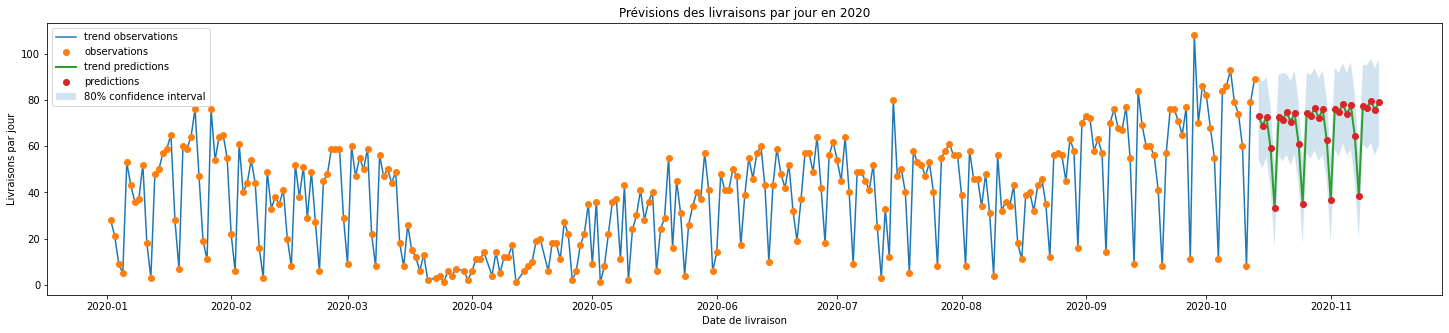

<Figure size 432x288 with 0 Axes>

In [54]:
fig, ax = plt.subplots(1,1, figsize=(25,5))
ax.plot(liv_day_train_prophet['ds'], liv_day_train_prophet["y"], "-")
#ax.fill_between(liv_day_train_prophet['ds'], liv_day_train_prophet["y"], alpha=0.2)
ax.plot(liv_day_train_prophet['ds'], liv_day_train_prophet["y"], 'o')
ax.plot(forecast_day['ds'], forecast_day["yhat"], '-', linewidth=2)
ax.fill_between(forecast_day['ds'], forecast_day["yhat_lower"],forecast_day["yhat_upper"], alpha=0.2)
ax.plot(forecast_day['ds'], forecast_day["yhat"], 'o')
ax.set_xlabel('Date de livraison')
ax.set_ylabel('Livraisons par jour')
ax.title.set_text('Prévisions des livraisons par jour en 2020')
plt.legend(['trend observations',"observations", "trend predictions",'predictions', "80% confidence interval"])
fig9 = plt.figure()

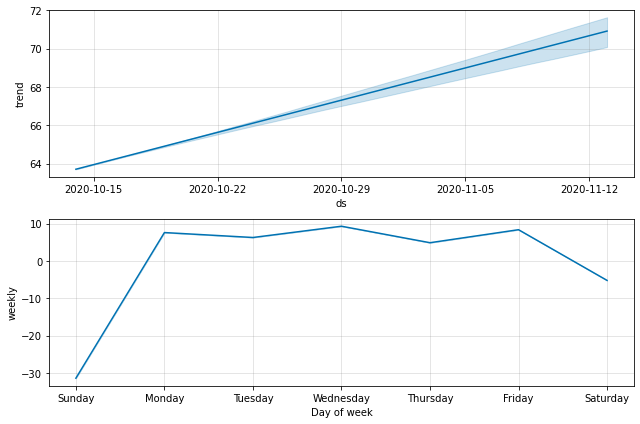

<Figure size 432x288 with 0 Axes>

In [55]:
fig_comp_day = m_day.plot_components(forecast_day)
fig10 = plt.figure()

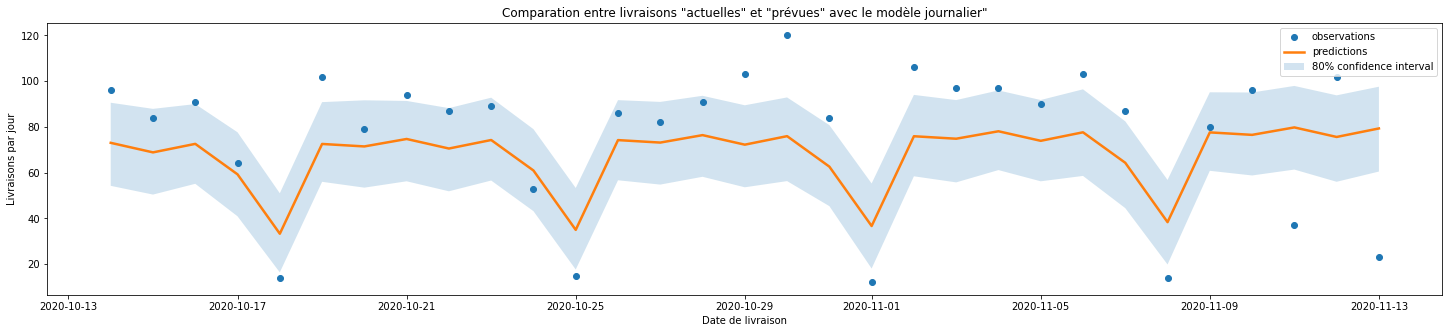

<Figure size 432x288 with 0 Axes>

In [57]:
fig, ax = plt.subplots(1,1, figsize=(25,5))
#ax.plot(liv_hr_test_prophet['ds'], liv_hr_test_prophet["y"], "-")
#ax.fill_between(liv_hr_test_prophet['ds'], liv_hr_test_prophet["y"], alpha=0.2)
ax.plot(liv_day_test_prophet['ds'], liv_day_test_prophet["y"], 'o')
ax.plot(forecast_day['ds'], forecast_day["yhat"], '-',linewidth=2.5)
ax.fill_between(forecast_day['ds'], forecast_day["yhat_lower"],forecast_day["yhat_upper"], alpha=0.2)
#ax.plot(forecast_hr['ds'], forecast_hr["yhat"], '.')
plt.legend(["observations", "predictions", "80% confidence interval"])
ax.set_xlabel('Date de livraison')
ax.set_ylabel('Livraisons par jour')
ax.title.set_text('Comparation entre livraisons "actuelles" et "prévues" avec le modèle journalier"')
fig11 = plt.figure()

#### 3d. Calculate MAPE

In [58]:
mape = mean_absolute_percentage_error(y_true=ds_liv_day_test['ID_livraison'],
                   y_pred=forecast_day['yhat'])

print("The MAPE on the test set for the Daily TS Model is : \n {}".format(mape))

The MAPE on the test set for the Daily TS Model is : 
 48.75142285970596


### 4. DAILY Model with French Holidays Analysis

In [59]:
from datetime import date

import holidays
m_holy = Prophet()
m_holy.add_country_holidays(country_name='FRA')

#### 3a. Instanciate Model with Holidays and make predictions

In [60]:
forecast_holy_day = m_holy.fit(liv_day_train_prophet).predict(liv_day_test_prophet)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [61]:
#forecast_holy_day.head()

#### 3b. Plot the different components of the holiday model

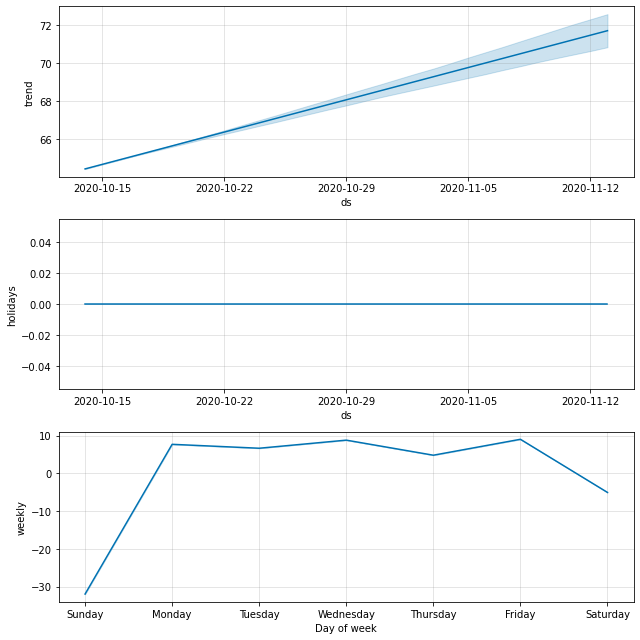

<Figure size 432x288 with 0 Axes>

In [62]:
fig_holy_day = m_holy.plot_components(forecast_holy_day)
fig12 = plt.figure()

#### 3c. Calculate MAPE

In [63]:
mape = mean_absolute_percentage_error(y_true=ds_liv_day_test['ID_livraison'],
                   y_pred=forecast_holy_day['yhat'])

print("The MAPE on the test set for the Daily TS Model with French Holidays is : \n {}".format(mape))

The MAPE on the test set for the Daily TS Model with French Holidays is : 
 48.42997731307682


### 5. DAILY Model Time Series Forecasting using Facebook's Prophet extra Regressor

#### 5a Preprocessing data
- adding 'Nombre de biens par mission' as regressor for Forecasting
- preprocess data to give in input to Prophet

In [64]:
#ds.head()

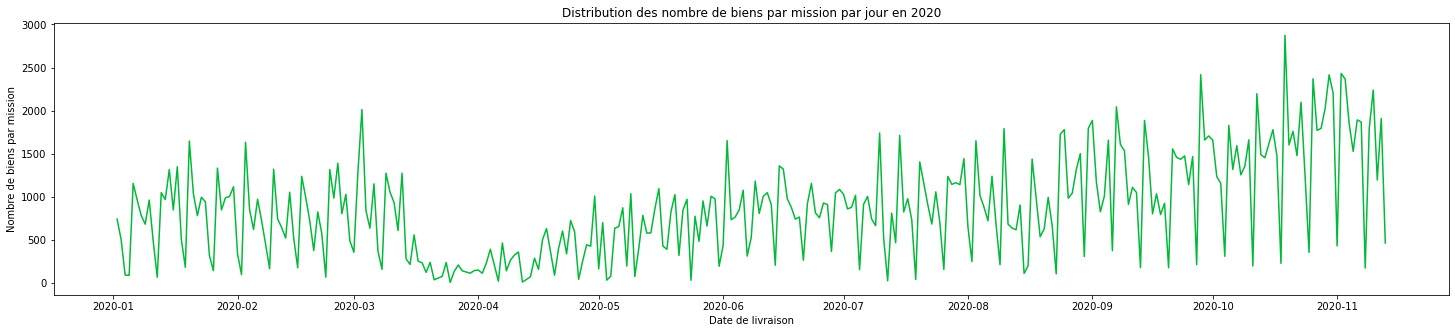

<Figure size 432x288 with 0 Axes>

In [65]:
fig, ax = plt.subplots(1,1, figsize=(25,5))
sns.lineplot(x=ds.index, y = ds["Nombre de biens par mission"], color = color_pal[3])
ax.set_xlabel('Date de livraison')
ax.set_ylabel('Nombre de biens par mission')
ax.title.set_text('Distribution des nombre de biens par mission par jour en 2020')
fig13 = plt.figure()

In [66]:
split_date = '2020-10-14 00:00:00'

ds_liv_hr_train = ds.loc[ds.index < split_date].copy()
ds_liv_hr_test = ds.loc[ds.index >= split_date].copy()

In [67]:
liv_add_train_prophet = ds_liv_hr_train.reset_index().rename(columns={'index':'ds','ID_livraison':'y', 'Nombre de biens par mission':'n_biens'})

In [68]:
liv_add_test_prophet = ds_liv_hr_test.reset_index().rename(columns={'index':'ds','ID_livraison':'y', 'Nombre de biens par mission':'n_biens'})

#### 5b. Instanciate Model with Regressor and make predictions

In [69]:
m_add= Prophet()
m_add.add_regressor('n_biens')
m_add.fit(liv_add_train_prophet)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [70]:
forecast_add = m_add.predict(liv_add_test_prophet)

In [71]:
#forecast_add.head()

#### 5c. Plot the different components of the holiday model

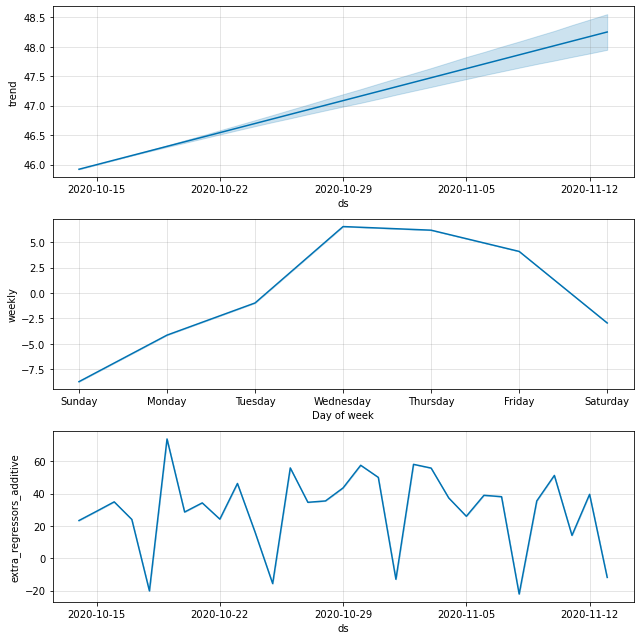

<Figure size 432x288 with 0 Axes>

In [72]:
fig_add = m_add.plot_components(forecast_add)
fig14 = plt.figure()

#### 5d. Plot forecasts vs actual

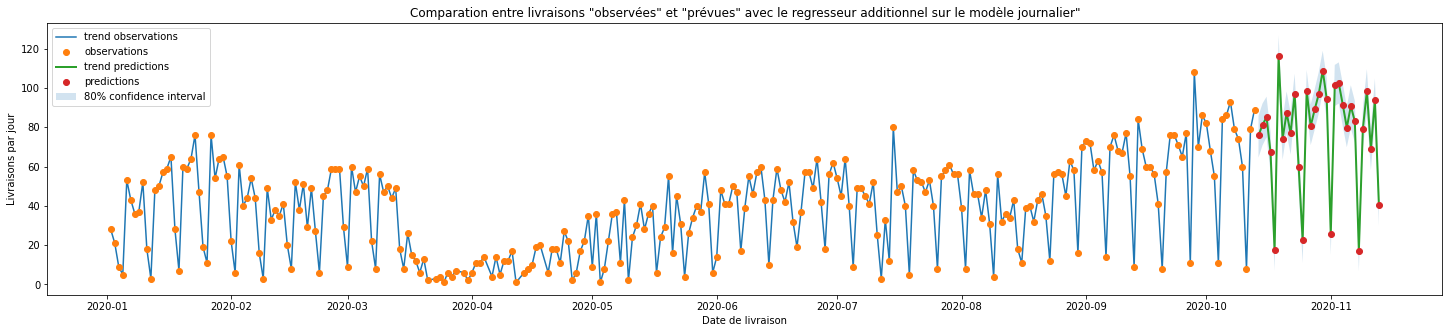

<Figure size 432x288 with 0 Axes>

In [73]:
fig, ax = plt.subplots(1,1, figsize=(25,5))
ax.plot(liv_day_train_prophet['ds'], liv_day_train_prophet["y"], "-")
#ax.fill_between(liv_day_train_prophet['ds'], liv_day_train_prophet["y"], alpha=0.2)
ax.plot(liv_day_train_prophet['ds'], liv_day_train_prophet["y"], 'o')
ax.plot(forecast_add['ds'], forecast_add["yhat"], '-', linewidth=2)
ax.fill_between(forecast_add['ds'], forecast_add["yhat_lower"],forecast_add["yhat_upper"], alpha=0.2)
ax.plot(forecast_add['ds'], forecast_add["yhat"], 'o')
ax.set_xlabel('Date de livraison')
ax.set_ylabel('Livraisons par jour')
plt.legend(['trend observations',"observations", "trend predictions",'predictions', "80% confidence interval"])
ax.title.set_text('Comparation entre livraisons "observées" et "prévues" avec le regresseur additionnel sur le modèle journalier"')
fig15 = plt.figure()

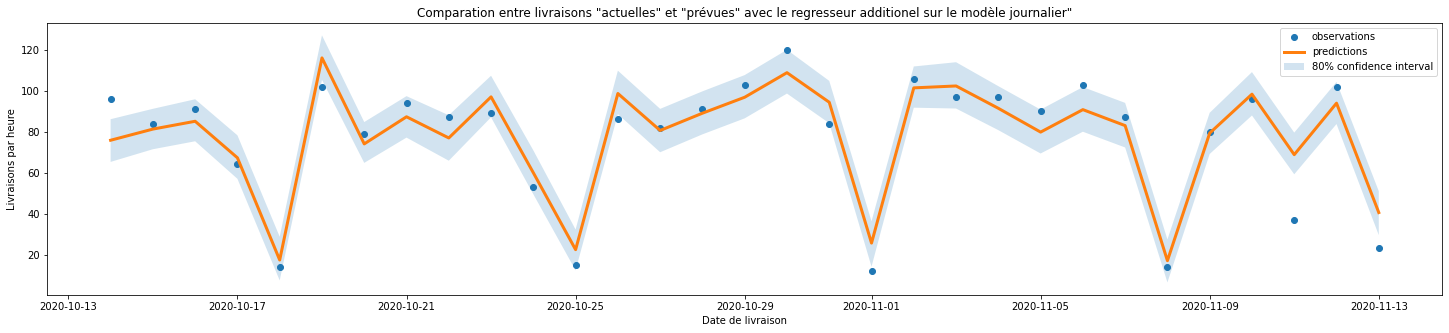

<Figure size 432x288 with 0 Axes>

In [79]:
fig, ax = plt.subplots(1,1, figsize=(25,5))
#ax.plot(liv_hr_test_prophet['ds'], liv_hr_test_prophet["y"], "-")
#ax.fill_between(liv_hr_test_prophet['ds'], liv_hr_test_prophet["y"], alpha=0.2)
ax.plot(liv_day_test_prophet['ds'], liv_day_test_prophet["y"], 'o')
ax.plot(forecast_add['ds'], forecast_add["yhat"], '-',linewidth=3)
ax.fill_between(forecast_add['ds'], forecast_add["yhat_lower"],forecast_add["yhat_upper"], alpha=0.2)
#ax.plot(forecast_hr['ds'], forecast_hr["yhat"], '.')
plt.legend(["observations", "predictions", "80% confidence interval"])
ax.set_xlabel('Date de livraison')
ax.set_ylabel('Livraisons par heure')
ax.title.set_text('Comparation entre livraisons "actuelles" et "prévues" avec le regresseur additionel sur le modèle journalier"')
fig16 = plt.figure()

#### 5e. Calculate MAPE

In [74]:
mape = mean_absolute_percentage_error(y_true=ds_liv_hr_test['ID_livraison'],
                   y_pred=forecast_add['yhat'])

print("The MAPE on the test set for the Daily TS Model with regressor 'N.of goods delivered' is : \n {}".format(mape))

The MAPE on the test set for the Daily TS Model with regressor 'N.of goods delivered' is : 
 18.31201977475389


#### 5f. Create a dataframe with CA and Livraisons forecasts of the best model based on min MAPE obtained 

In [76]:
#forecast_CA = pd.read_csv('xxx_forecasts_Nov2020.csv')

In [77]:
#forecast_CA.set_index('Date_livraison', inplace=True)

In [78]:
forecast_livraisons = pd.DataFrame(forecast_add[['ds','yhat']])
forecast_livraisons = forecast_livraisons.rename(columns={"ds": "Date_livraison", "yhat": "N_livraison_prévisionnel"})
forecast_livraisons.set_index('Date_livraison', inplace=True)
forecast_livraisons['N_livraison_prévisionnel'] = forecast_livraisons['N_livraison_prévisionnel'].round()

In [79]:
Last_month_forecasts_2020 = pd.merge(forecast_CA, forecast_livraisons, left_index=True, right_index=True)

NameError: name 'forecast_CA' is not defined

In [78]:
Last_month_forecasts_2020.to_csv('xxx_forecasts_Nov2020_comp.csv')

#### Plot daily livraisons vs n.bien mission distributions

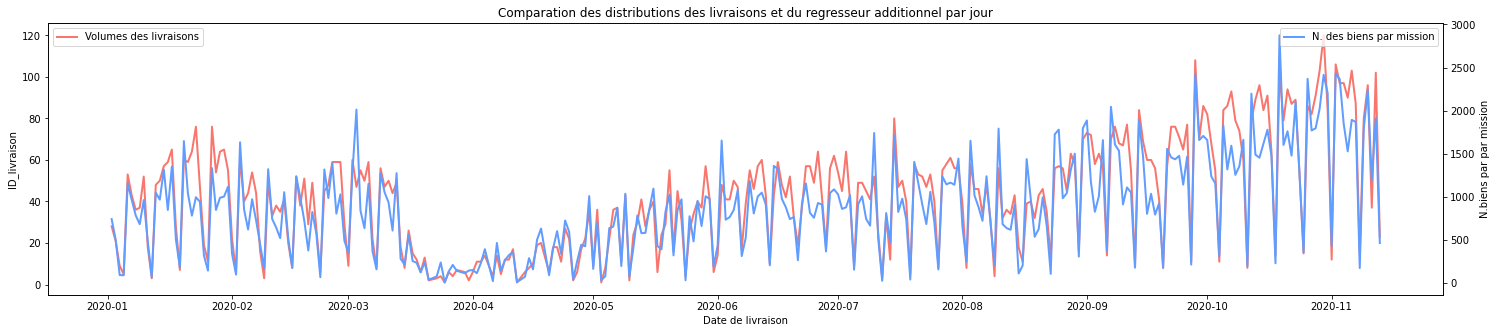

<Figure size 432x288 with 0 Axes>

In [80]:
fig, ax = plt.subplots(1,1, figsize=(25,5))
ax = sns.lineplot(x=ds.index, y = ds["ID_livraison"], color = color_pal[0], linewidth= 2)
ax2 = ax.twinx()
sns.lineplot(x=ds.index, y = ds["Nombre de biens par mission"], color = color_pal[6],linewidth= 2)
ax.set_xlabel('Date de livraison')
ax2.set_ylabel('N.biens par par mission')
ax.legend(['Volumes des livraisons'], loc='upper left')
ax2.legend(["N. des biens par mission"], loc='upper right')
ax.title.set_text("Comparation des distributions des livraisons et du regresseur additionnel par jour")
fig17= plt.figure()